In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import ipywidgets as widgets
import shapefile as shp
import matplotlib.ticker as ticker
import os
import cartopy.crs as ccrs



def read_shapefile(file_address):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column holding
    the geometry information. This uses the pyshp package
    To use this function, you need to install pyshp first
    """
    import shapefile as shp
    sf = shp.Reader(file_address)
    shapes = sf.shapes()
    points = shapes[0].points
    x_lon = [i[0] for i in points]
    y_lat = [i[1] for i in points]
    return x_lon, y_lat


def plot2d(parameter1, parameter2, parameter3, parameter4, parameter5):
    # parametr1 --> seismic parameters like vp, vs, density
    # parametr2 --> depth
    # parameter3 --> gridding method such as linear, nearest, cubic
    df = pd.read_csv("inv/plot3d/complete_file.csv")
    physical_parameter = parameter1
    zlevel = parameter2
    method = parameter3
    depth_delta = 100
    df = df[(df["depth"] < zlevel + depth_delta) & (df["depth"] > zlevel - depth_delta)].reset_index(drop=True)
    lat = df["lat"]
    lon = df["lon"]
    depth = df["depth"]
    m = df[physical_parameter]
    sta = df["sta"]
    
    # Interpolate
    resolution = parameter4

    x = np.linspace(lon.min(), lon.max(), resolution)
    y = np.linspace(lat.min(), lat.max(), resolution)
    grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
    grid_m = griddata((lon, lat), m, (grid_x, grid_y), method=method)
    kw = {
        "levels": np.linspace(m.min(), m.max(), 10)
    }
    # plot
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    C = ax.contour(grid_x, grid_y, grid_m, **kw)
    # ax.contour(grid_x, grid_y, grid_m, colors='black', linewidths=0.5, levels = 10)

    # Set labels and zticks
    ax.set(
        xlabel='Lon. [deg]',
        ylabel='Lat. [deg]',
    )
    #plotting stations and colorbar
    label = {"vp": "Vp [km/s]", "vs": "Vs [km/s]", "rho": "Density [g/cm^3]", "dip": "Dip [deg]", "ani": "Anisotropy [%]"}
    fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label=label[parameter1])
    for i, txt in enumerate(sta):
        ax.scatter(lon[i], lat[i], c='r', s=10, marker='o')
        rnd_vl_lat = np.random.uniform(-1, 1)*0.1
        rnd_vl_lon = np.random.uniform(-1, 1)*0.1
        ax.text(lon[i]+rnd_vl_lon, lat[i]+rnd_vl_lat, txt, color='black', fontsize=8, visible=True)
    #plotting shapefile
    if parameter5:
        x_lon, y_lat = read_shapefile("Hudbay/HudsonBay.shp")
        ax.plot(x_lon, y_lat, color="black", linewidth=1.5)

    ax.set_xlim(lon.min()-1, lon.max()+1)
    ax.set_ylim(lat.min()-1, lat.max()+1)
    fmt = ticker.LogFormatterMathtext()
    fmt.create_dummy_axis()
    ax.clabel(C, fmt=fmt, inline=True, fontsize=10, colors='black')

    plt.grid()
    plt.show()

parameter1 = widgets.Dropdown(options=["vp", "vs", "rho", "dip", "ani"], description='Attribute:', value='vs')
parameter2 = widgets.IntSlider(min=0, max=50000, step=2000, description='Depth [km]:', value=0)
parameter3 = widgets.Dropdown(options=["nearest", "linear", "cubic"], description='Gridding method:', value='linear')
parameter4 = widgets.IntSlider(min=20, max=200, step=10, description='Resolution:', value=100)
parameter5 = widgets.Checkbox(value=False, description='HudsonBay shapefile')
widgets.interactive(plot2d, parameter1=parameter1, parameter2=parameter2, parameter3=parameter3, parameter4=parameter4, parameter5=parameter5)


interactive(children=(Dropdown(description='Attribute:', index=1, options=('vp', 'vs', 'rho', 'dip', 'ani'), v…

# 3D plot

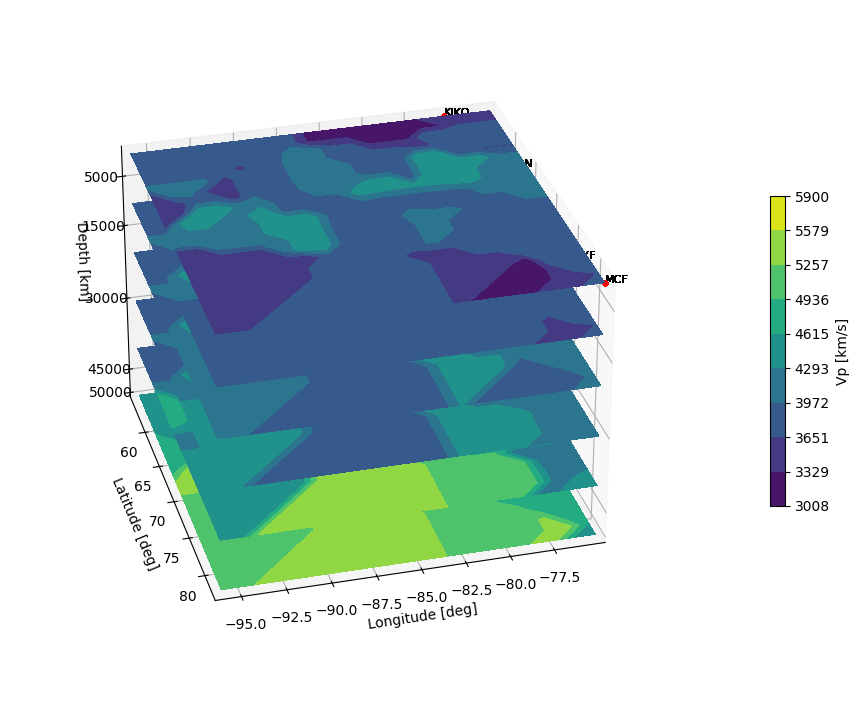

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import ipywidgets as widgets

df = pd.read_csv("inv/plot3d/complete_file.csv")
lat = df["lat"]
lon = df["lon"]
depth = df["depth"]
m = df["vs"]
sta = df["sta"]

# Interpolate
zlevels = 6
resolution = 20

x = np.linspace(lon.min(), lon.max(), resolution)
y = np.linspace(lat.min(), lat.max(), resolution)
z = np.linspace(depth.min(), depth.max(), zlevels)
grid_x, grid_y, grid_z = np.meshgrid(x, y, z, indexing='ij')
grid_m = griddata((lon, lat, depth), m, (grid_x, grid_y, grid_z), method='nearest')
kw = {
    "levels": np.linspace(m.min(), m.max(), 10)
}

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#z
for i in range(zlevels):
    C = ax.contourf(grid_x[:,:,i], grid_y[:,:,i], grid_m[:,:,i], zdir='z', offset=grid_z[:,:,i].min(), **kw)
    
xmin, xmax = grid_x.min(), grid_x.max()
ymin, ymax = grid_y.min(), grid_y.max()
zmin, zmax = grid_z.min(), grid_z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])


# Set labels and zticks
ax.set(
    xlabel='Longitude [deg]',
    ylabel='Latitude [deg]',
    zlabel='Depth [km]',
    zticks=[5000, 15000, 30000, 45000, 50000],
)

ax.view_init(-150, -75)
ax.set_box_aspect(None, zoom=0.9)

fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Vp [km/s]')
for i, txt in enumerate(sta):
    ax.scatter(lon[i], lat[i], -1, c='r', s=10, marker='o', label='station')
    ax.text(lon[i], lat[i], -1, txt, color='black', fontsize=8, visible=True)
plt.show()


# Moho Map

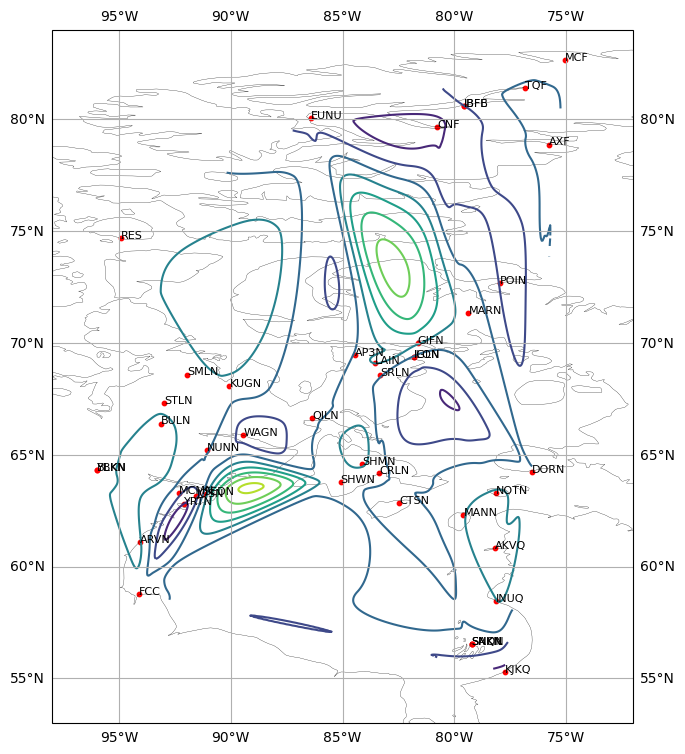

In [4]:
def text_scatter(ax, x, y, txt):
    for i, txt in enumerate(txt):
        ax.text(x[i], y[i], txt, color='black', fontsize=8, visible=True)
    return ax

# def _reading_file(whcih_file):
which_file = "flatmoho"
path=f"inv/plot3d/{which_file}/bird-view/"
files = [i for i in os.listdir(path) if "short" in i]
moho = []
for file in files:
    stn_code = file.split("%")[0]
    lat = float(file.split("%")[2])
    lon = float(file.split("%")[3])
    file_df = pd.read_csv(path+file)
    below_moho = file_df[file_df.index == file_df.index.max()]
    moho_depth = below_moho["depth"].values[0]
    moho_vs = below_moho["vs"].values[0]
    moho_vp = below_moho["vp"].values[0]
    moho_rho = below_moho["rho"].values[0]
    moho_dip = below_moho["dip"].values[0]
    moho_strike = below_moho["strike"].values[0]
    moho_ani = below_moho["ani"].values[0]
    moho_plunge = below_moho["plunge"].values[0]
    moho_trend = below_moho["trend"].values[0]
    station_info = (stn_code, lat, lon, moho_depth, moho_vs, moho_vp, moho_rho, moho_dip, moho_strike, moho_ani, moho_plunge, moho_trend)
    moho.append(station_info)
moho_df = pd.DataFrame(moho,
                       columns=["stn_code", "lat", "lon", "moho_depth", "moho_vs", "moho_vp", "moho_rho", "moho_dip", "moho_strike", "moho_ani", "moho_plunge", "moho_trend"])
#save the moho_df
moho_df.to_csv("inv/plot3d/moho_df.csv", index=False)
# def plot_contour_moho(depth):
feature = "moho_depth"
x = moho_df["lon"]
y = moho_df["lat"]
m = moho_df[feature]
sta = moho_df["stn_code"]
# Interpolate
resolution = 500
method = "cubic"
X = np.linspace(x.min(), x.max(), resolution)
Y = np.linspace(y.min(), y.max(), resolution)
grid_x, grid_y = np.meshgrid(X, Y, sparse=True)
grid_m = griddata((x, y), m, (grid_x, grid_y), method=method)


plt.figure(figsize=(9, 9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(color="black", linewidth=0.2, resolution='50m')
ax.contour(X, Y, grid_m)
ax.set_extent([-98, -72, 53, 84], crs=ccrs.PlateCarree())
ax.set_facecolor('white')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.scatter(x, y, c='r', s=10, marker='o')
ax = text_scatter(ax, x, y, sta)
# ax.stock_img()
plt.show()